# TIØ4317 - Mini Project Report

If possible, view the report on google colab as it has all the neccessary figures: https://colab.research.google.com/drive/1-bwVLkEdyx1HjbkoY0TKpmA6cOhL5pkS?usp=sharing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model


/Users/philipmaurstaduv/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/philipmaurstaduv/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


## Introduction & Problem Statement

Trading Bitcoin (BTC) can be very challenging due to its high volatility and unpredictable price movements. Traditional trading methods often rely heavily on intuition or basic indicators, which might not perform well under complex market conditions. To tackle this problem, there's a clear need for more reliable and data-driven approaches that use past price data to predict future price movements accurately. This project aims to develop algorithmic trading strategies by combining machine learning and statistical methods. Using historical BTC/USD market data from 2020 to 2023, our goal is to create strategies that can maximize profits and manage risks effectively when trading Bitcoin in 2024.

## Data

For this project, we will use historical market data for Bitcoin (BTC/USD) from January 1, 2020, to December 31, 2024. The data was extracted with 4 hour intervals from Binance, a well-known cryptocurrency exchange. Consult `fetch_btc_data.py` for furhter insights about the data collection process.

### Data description

The data file extracted from Binance consists of the following columns: *Open Time, Open, High, Low, Close, Volume, Close Time, Quote Asset Volume, Trades, Taker Base Volume,  Taker Quote Volume, Ignore*. After collecting the data, we convert it into a structured format using Python’s Pandas library. We then split the data into training and test sets. Data from January 2020 to December 2023 is used for training (`BTCUSDT_4h_train_data.csv`), while the data from 2024 is used for validation (`BTCUSDT_4h_test_data.csv`).

In [2]:
btc_train = pd.read_csv("BTCUSDT_4h_train_data.csv")
btc_test = pd.read_csv("BTCUSDT_4h_test_data.csv")

btc_train["Close Time"] = pd.to_datetime(btc_train["Close Time"])
btc_train.set_index("Close Time", inplace=True)
btc_test["Close Time"] = pd.to_datetime(btc_test["Close Time"])
btc_test.set_index("Close Time", inplace=True)

In [3]:
# Only for 'close' and 'volume'
desc_stats = btc_train[['Close', 'Volume']].describe()
print(desc_stats)

              Close         Volume
count   9000.000000    9000.000000
mean   29221.852912   65209.306814
std    15081.152786   55899.521277
min     4553.390000    4452.648000
25%    17111.955000   30302.682750
50%    27735.150000   48778.104500
75%    41051.125000   81261.771000
max    68563.980000  996111.854000


Some of the most interesting data here is the *Close* and *Volume*. From the statistics above we can see that the average closing price for one Bitcoin during the training data period was 29,211.85 USD. The standard deviation in the same period is 15,081.5, with a maximum peak of 68,563.98 and low point at 4,553.39. The standard deviation is quite high compared to the mean, highlighting the extreme volatility of Bitcoin. The closing price plot shows a gradual increase on average between 2020 and 2024, with a long period of higher peaks in 2021 and 2022 before normalizing in 2023.

<Axes: xlabel='Close Time'>

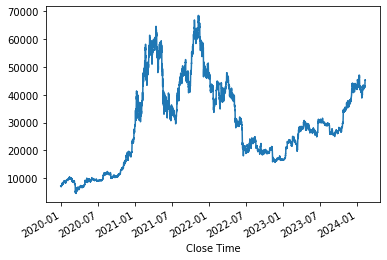

In [13]:
# Visual inspesction of time series
btc_train['Close'].plot()

The high volatility also applies to the trade volume. The average volume was 65,209.31, with a relatively high standard deviation of 55,889.52. The volume range is also considerable, ranging from 4,452.65 to 996,111.85. The high peaks clearly stand out:

<Axes: xlabel='Close Time'>

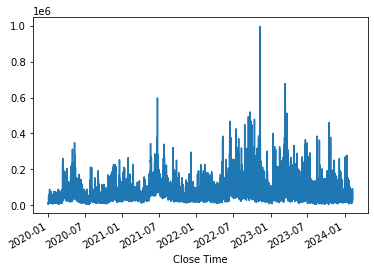

In [14]:
# Visual inspection of trading volume
btc_train['Volume'].plot()

### Data processing
To prepare the data for analysis, we first retrieve historical Bitcoin market data from the Binance API, specifically using intra-daily candle information for the BTC/USD pair with four hour intervals. Each candle provides important details, mainly opening and closing prices, high and low prices, and traded volume.

Once the raw data is collected, we start the preprocessing stage. First, any data points with zero trading volume are removed to maintain data quality. We then compute several technical indicators to help predict price trends:


* **Hull Moving Averages (HMA):** Two HMAs (fast and slow) are calculated based on different periods (10 and 30). HMAs smooth out the price data and help us identify short-term and long-term trends.
* **Supertrend Indicator:** This indicator uses the Average True Range (ATR) to detect market volatility and define upper and lower bands, which indicate potential trend directions (bullish or bearish).


After computing these indicators, we generate trading signals based on their combined results. Specifically:


*   A **buy signal** is generated when the fast HMA crosses above the slow HMA, and the Supertrend indicator signals an uptrend.
*   A **sell signal** is generated when the fast HMA crosses below the slow HMA, and the Supertrend indicates a downtrend.
*   If neither condition is met, no trading signal is generated.


Finally, the trading signals are refined to ensure clarity and avoid duplicate signals, marking each signal explicitly as a "long," "short," or "close" trade. This processed and structured dataset is then used to perform a backtest, allowing us to evaluate the profitability and effectiveness of our trading strategies.


## Empirical Analysis
This section will describe all steps in the empirical analisys that was used to form the trading strategies. These steps includes stationarity checks, investigation of heteroscedasticity and autocorrelation, fiting of ARIMA models, volatility measures, moving averages models and an ensamble ML model.



### Stationarity

A lot of statistical time series models, including ARIMA, assumes stationary data. A process is said to be stationary if its statistical properties, like mean and variance, do not change over time. The dataset can be controlled for stationarity through the augmented Dickey-Fuller (ADF) test. This tests has a null hypothesis saying that the time series has a unit root, which is a key indicator of non-stationarity.

In [15]:
def adfTest(data):
    adf = adfuller(data)
    print(f'ADF Statistic: {adf[0]}')
    print(f'p-value: {adf[1]}')

    if adf[1] > 0.05:
        print('The data is not stationary')
    else:
        print('The data is stationary')

adfTest(btc_train["Close"])

ADF Statistic: -1.7355336892062028
p-value: 0.4129036578090112
The data is not stationary


The ADF test gave a p-value equal to 0.42, over the threshold of 0.05, meaning that there is not significant statisitcal evidence to reject the null hypothesis and assume that the data is stationary. Models like ARIMA assume stationarity. Hence, it is necessary to make the data stationary to make correct statistical inferences. One simple method for making data stationary is to take the first difference.
<br/>
<br/>
The first difference of a time series ( $X_t $) is defined as:

$$
\Delta X_t = X_t - X_{t-1}
$$



This transformation is commonly used to remove trends and make a non-stationary time series stationary.

In [19]:
df_first_diff = btc_train.copy()

#We take the first difference
df_first_diff['close_diff'] = df_first_diff['Close'].diff().dropna()
df_first_diff = df_first_diff.dropna()

#Then we test for stationarity again
adfTest(df_first_diff['close_diff'])

ADF Statistic: -14.186321859286243
p-value: 1.89013388961956e-26
The data is stationary


We now obtain a p-value of 1.89e-26 from the ADF test. This is below the significance level of 0.05, and we can reject the null hypothesis of non-stationarity. Thus, applying the first difference made the data stationary.

We can then plot the data with first difference to inspect whether the data looks to be stationary.

<Axes: xlabel='Close Time'>

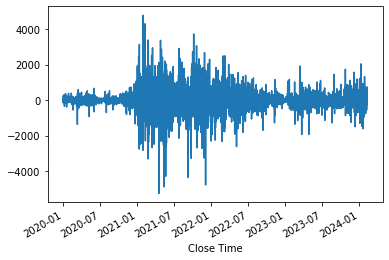

In [20]:
df_first_diff['close_diff'].plot()

The plot displays that the mean now seems to be constant over time. However, the variance is not constant over time and points in time of low (high) volatility seems to be followed by low (high) volatility. This could indicate volatility clustering, which will be looked into in more detail during the residual diagnostic. Note that for the rest of this report when reffering to the data set, we mean the data set with first difference.

### Investigating Autocorrelation

The next step is to investicate whether the data has autocorrelation and partial autocorrelation. We do this by plotting ACF and PACF curves. Starting with ACF curve. ACF curves show the pearson correlation of a time series with its past values, including indirect effects.

Lag 1: ACF = -0.038
Lag 2: ACF = 0.030
Lag 3: ACF = 0.025
Lag 6: ACF = -0.056
Lag 12: ACF = -0.032
Lag 15: ACF = 0.029
Lag 19: ACF = -0.038
Lag 23: ACF = 0.040
Lag 24: ACF = -0.031
Lag 25: ACF = 0.026
Lag 26: ACF = 0.023
Lag 30: ACF = 0.025
Lag 32: ACF = -0.030
Lag 33: ACF = -0.021
Lag 34: ACF = 0.035
Lag 35: ACF = 0.034
Lag 38: ACF = 0.026
Lag 53: ACF = 0.035
Lag 56: ACF = 0.027
Lag 57: ACF = -0.022
Lag 69: ACF = -0.023
Lag 74: ACF = -0.023
Lag 75: ACF = 0.030


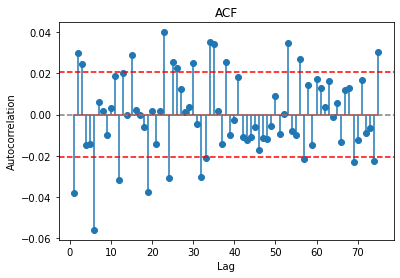

In [21]:
# Compute ACF
acf_vals = acf(df_first_diff['close_diff'].dropna(), nlags=75, fft=True)[1:]
lags = np.arange(1, len(acf_vals) + 1)

# 95% confidence interval
conf_int = 1.96 / np.sqrt(len(df_first_diff['close_diff'].dropna()))

# Finding significant lags
significant_mask = (acf_vals > conf_int) | (acf_vals < -conf_int)
significant_lags = lags[significant_mask]
significant_acfs = acf_vals[significant_mask]

# Printing significant lags and values
for lag, val in zip(significant_lags, significant_acfs):
    print(f"Lag {lag}: ACF = {val:.3f}")

# Plotting ACF curve
plt.stem(lags, acf_vals)
plt.axhline(0, linestyle='--', color='gray')
plt.axhline(conf_int, linestyle='--', color='red')
plt.axhline(-conf_int, linestyle='--', color='red')
plt.title('ACF')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

The plot demonstrates that the data exhibits autocorrelation, with lags 1, 6, 19 and 23 being the most significant. We then plot a PACF curve. PACF removes all indirect effects and shows the direct effect of past values on the time series.

Lag 1: ACF = -0.038
Lag 2: ACF = 0.029
Lag 3: ACF = 0.027
Lag 6: ACF = -0.057
Lag 12: ACF = -0.033
Lag 15: ACF = 0.030
Lag 19: ACF = -0.036
Lag 23: ACF = 0.041
Lag 24: ACF = -0.031
Lag 26: ACF = 0.023
Lag 30: ACF = 0.022
Lag 32: ACF = -0.027
Lag 33: ACF = -0.024
Lag 34: ACF = 0.038
Lag 35: ACF = 0.046
Lag 37: ACF = -0.021
Lag 41: ACF = 0.021
Lag 53: ACF = 0.036
Lag 56: ACF = 0.024
Lag 57: ACF = -0.022
Lag 69: ACF = -0.025
Lag 75: ACF = 0.026


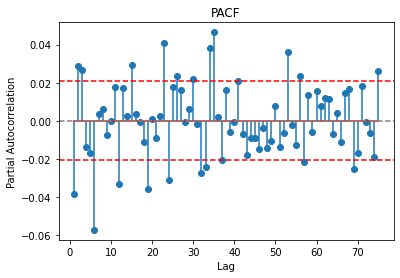

In [22]:
pacf_vals = pacf(df_first_diff['close_diff'].dropna(), nlags=75)
lags = np.arange(1, len(acf_vals) + 1)
pacf_vals = pacf_vals[1:]

# Find significant lags
significant_mask = (pacf_vals > conf_int) | (pacf_vals < -conf_int)
significant_lags = lags[significant_mask]
significant_pacfs = pacf_vals[significant_mask]

# Print significant lags and values
for lag, val in zip(significant_lags, significant_pacfs):
    print(f"Lag {lag}: ACF = {val:.3f}")

plt.stem(lags, pacf_vals)
plt.axhline(0, linestyle='--', color='gray')
plt.axhline(conf_int, linestyle='--', color='red')
plt.axhline(-conf_int, linestyle='--', color='red')
plt.title('PACF')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()


The PACF plot is very similar to the ACF plot and demonstrates that the timeseries also exhibits partial autocorrelation. Lags 1, 6, 23 and 35 are most significant.

In summary the plots show many small, but statisitcally significant spikes, most of them being negative. The large sample size (~9000 data points) is making even small autocorrelations and partial autocorrelations statistically significant. However, none of the spikes are especially large, with the most significant value for both ACF and PACF lying around -0.06. This implies very weak autocorrelation and partial autocorrelation.

### ARIMA models

The next step is to fit various ARIMA models to the data and select the best one. We have discovered that the data exhibits autocorrealation, but due to very small correlation values, we begin with simple ARIMA models. We fear that using too complex models will result in overfitting due to the small autocorrelation values.

We use the python library `pmdarima` to search through different orders of the ARIMA model and return the one with the best Akaike Information Criterion (AIC). We search through *p*- and *q*-values ranging from 0-5. The *d* is set to 1 so that the model internally takes the first difference as concluded in the stationarity section.

In [25]:
# We use Auto ARIMA to find the best order with p and q ranging from 0 to 10
sample_model = pm.auto_arima(df_first_diff['Close'].dropna(),
                             d = 1,
                             seasonal=False,
                             stepwise=True,
                             trace=True,
                             max_p=5,
                             max_q=5)
print(sample_model.summary())
# We can also use the AIC to find the best order
print(f"AIC: {sample_model.aic()}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=136755.303, Time=3.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=136795.662, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=136784.530, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=136785.282, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=136794.349, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=136777.456, Time=1.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=136778.830, Time=2.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=136777.750, Time=2.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=136743.412, Time=5.97 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=136766.582, Time=3.45 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=136759.360, Time=6.62 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=136744.718, Time=14.48 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=136765.491, Time=8.29 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=136739.044, Time=13.52 sec
 AR

The optimal order found is ARIMA(5,1,5) with an AIC equal to 136733. ARIMA(4,1,4) performs slightly worse, but is still plausible with an AIC value of 136736. We then fit an ARIMA(5,1,5) model for further investigations.

In [28]:
model = ARIMA(btc_train['Close'], order=(5,1,5))
arima_results = model.fit()
print(arima_results.summary())


/Users/philipmaurstaduv/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4h will be used.
  self._init_dates(dates, freq)
/Users/philipmaurstaduv/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4h will be used.
  self._init_dates(dates, freq)
/Users/philipmaurstaduv/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4h will be used.
  self._init_dates(dates, freq)
/Users/philipmaurstaduv/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 8999
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -68355.487
Date:                Sat, 05 Apr 2025   AIC                         136732.975
Time:                        09:57:40   BIC                         136811.127
Sample:                    01-01-2020   HQIC                        136759.568
                         - 02-08-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3422      0.106      3.241      0.001       0.135       0.549
ar.L2          0.1641      0.047      3.477      0.001       0.072       0.257
ar.L3         -0.1774      0.030     -5.843      0.0

The output of the ARIMA models shows several interesting aspects. Firstly, all coefficients are statistically significant. Secondly, the Ljung-Box test performed on the fitted model has a p-value equal to 0.36, meaning that there is no significant statistical evidence to reject the null hypothesis. Hence, we can conclude that there is no autocorrelation in the residuals, meaning that the model has managed to explain the correlation in the data. The summary also shows the results of an ARCH test to test for heteroskedasticity. The test result shows strong evidence of heteroskedasticity, which needs to be taken care of. Lastly, the Jarque-Bera (JB) test shows evidence of non-normal residuals. The skew and kurtosis further suggest a heavy left tail and extremely fat tails, confirming the results form the JB test. In summary, heteroskedastic and fat-tailed residuals suggest that the ARIMA model alone is not sufficient to model BTC/USD returns, and that some volatility measure is necessary.

### Volatility Measure

Volatility measure is a important attribute to investigate when searching for optimal trading strategies. Most of the buy/sell indicators requires info on market volatility conditions to avoid taking risky trading decisions. When the bitcoin market is highly volatile, the risk increases too. We have already ideentified that the residuals of the ARIMA(5,1,5) model is heteroskedastic with fat tails. Consequently, ARIMA alone may not be sufficient to develop a trading strategy. To cacluate volatility trends and predict volatility we used the GARCH-t and HAR models respectively.

In [4]:
#btc_data = pd.read_csv('BTCUSDT_1d_all_data.csv')
#btc_data['Open Time'] = pd.to_datetime(btc_data['Open Time'])
#btc_data.set_index('Open Time', inplace=True)
#btc_data.sort_index(inplace=True)


btc_train['Returns'] = btc_train['Close'].pct_change().dropna()
btc_train.dropna(subset=['Returns'], inplace=True)
scaled_returns = btc_train['Returns'] * 100

First we applied GARCH(1,1) with Student's t-distributed errors. This distribution was used due to the non-normal residual characteristics identified earlier. A GARCH($p$, $q$) model consists of two main components:


1.   A mean equation, which models the return as a function of past information. In our case an ARIMA(2,1,1) model:
  

  <center>$\Delta y_t = \mu + \phi_1 \Delta y_{t-1} + \phi_2 \Delta y_{t-2} + \theta_1 \epsilon_{t-1} + \epsilon_t$ </center>
  
  2. A variance equation, which specifies how the conditional variance $\sigma_t^2$ evolves over time:
  <center>$\sigma_t^2 = \omega + \sum_{i=1}^{q} \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^{p} \beta_j \sigma_{t-j}^2$</center>

We fitted a GARCH(1,1) model to the residuals.


In [29]:
garch_model = arch_model(arima_results.resid, vol='Garch', p=1, q=1, dist='t')
garch_results = garch_model.fit(disp="off")
print(garch_results.summary())


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -62940.9
Distribution:      Standardized Student's t   AIC:                           125892.
Method:                  Maximum Likelihood   BIC:                           125927.
                                              No. Observations:                 8999
Date:                      Sat, Apr 05 2025   Df Residuals:                     8998
Time:                              09:57:42   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             3

/Users/philipmaurstaduv/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.38e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


The results show that all coefficients are statistically significant. The residuals still have a slightly positive mean (μ = 3.76). The α coefficient measures the impact of recent shocks. A value of 0.0622 demonstrates an positive relationship to recent shocks and indicates that ~6% of todays volatility can be explained by the most recent shock. This coefficient is higly significant, providing evidence that there is short-term volatility reaction to news in the BTC/USD market.

The β coefficient measures volatility persistence, describing how long it takes for volatility to die out. A β of 0.9378 suggests extremely persistent volatility. Furthermore, the fact that α + β ≈ 1 suggests strong volatility clustering as suggested by the plot earlier. This suggests that shocks to volatility in the BTC/USD market take a long time to decay.

Next we apply HAR to predict volatility:

/var/folders/72/z32mg6zj7ms4yb4k2v3wljd40000gn/T/ipykernel_89612/2431935487.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_har['Constant'] = 1



HAR Model Summary:
                            OLS Regression Results                            
Dep. Variable:               RV_Daily   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     4939.
Date:                Sat, 05 Apr 2025   Prob (F-statistic):               0.00
Time:                        10:00:56   Log-Likelihood:                -9262.0
No. Observations:                8977   AIC:                         1.853e+04
Df Residuals:                    8973   BIC:                         1.856e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RV_Daily     961.4114      8.638

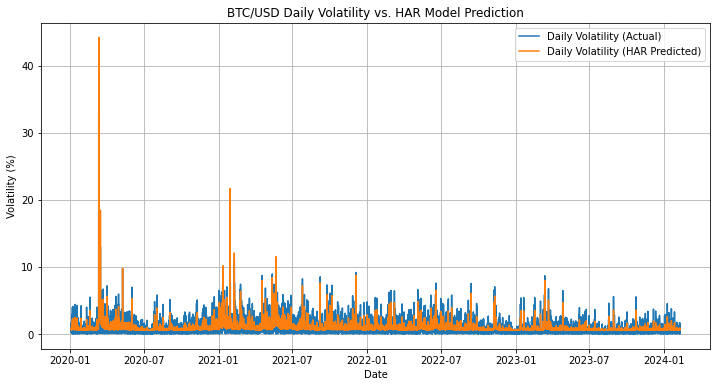

In [30]:
btc_train['RV_Daily'] = btc_train['Returns']**2
btc_train['RV_Weekly'] = btc_train['RV_Daily'].rolling(window=5).mean().shift(1)
btc_train['RV_Monthly'] = btc_train['RV_Daily'].rolling(window=22).mean().shift(1)

btc_data_har = btc_train.dropna()

import statsmodels.api as sm

y_har = np.sqrt(btc_data_har['RV_Daily']) * 100 # Predict daily volatility
X_har = btc_data_har[['RV_Daily', 'RV_Weekly', 'RV_Monthly']]
X_har['Constant'] = 1

model_har = sm.OLS(y_har, X_har)
results_har = model_har.fit()

print("\nHAR Model Summary:")
print(results_har.summary())

plt.figure(figsize=(12, 6))
plt.plot(y_har.index, y_har, label='Daily Volatility (Actual)')
plt.plot(y_har.index, results_har.fittedvalues, label='Daily Volatility (HAR Predicted)')
plt.title('BTC/USD Daily Volatility vs. HAR Model Prediction')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.show()

Inferences from HAR:

RV_Daily (961.4114):
This high and significant coefficient indicates that the most recent day’s volatility has a strong direct influence on current volatility.

RV_Weekly (12.4794):
A positive coefficient, suggesting that the average volatility over the past week also contributes to the current day’s volatility, albeit with a smaller magnitude. However, the coefficient is not statistically significant.

RV_Monthly (504.7750):
This coefficinet is large and significant, indicating that longer-term volatility (over a month) plays an important role.

R-squared = 0.623:
About 62% of the variation in daily volatility is explained by the model, which is a decent fit.

The HAR model confirms that short-term (daily) volatility has the strongest influence on current volatility, but medium-term (monthly) and volatilities also matter. The medium high R-squared suggests that these historical measures capture a substantial part of the variance in current volatility.

### Market Entry/Exit Indicators

The following two approaches were used to indicate market entry or exit:

1. ML Based: ARIMA, CatBoost, LightGBM, XGBoost and ensebmle of later three were experimented to predict return % after nth day at a particular time stamp. If the return would be negative, it would indicate market exit, if return would be positive, it would indicate a market entry.

2. Stastistical Based: Moving average based indicators like SMA, EMA, Hull MA etc were investigated. At each time stamp a slow MA (averaging over longer/more past days) and a fast MA (averaging over small number of past days) is calculated. If fast MA > slow MA, it indicates market entry and market exit would be indicated if otherwise.

### Emprirical Analysis Conclusion

The following conclusions could be made about BTC/USD marked by our analysis:

1. BTC has stable movements with fewer extreme fluctuations, resulting in overall lower but persistant volatility.

2. Presence of heteroscedasticity and weak autocorrelation and partial autocorrelation.

3. BTC exhibits more predictable trend driven movement characterized by extended uptrends or downtrends. Hence trend based strategies may be well suited.

4. Indicators based on moving averages may lead to inaccurate decisions in durations of highly choppy market.

## Trading Strategy

An easier overview of our trading strategy can be explained in the following way:

![Trading_Strat](strategy_chart.png)

At every time stamp in our data we first decide weather to trade or not, and if yes, we check the market indicators to make a decision to enter/exit the market. To keep things simple, "Buy" means buying all BTC with current available USD portfolio, and "Sell" means selling all BTC.

Multiple trading models and strategies were tried, and they could be broadly classified into two:

1. ML Based: The ML models were required to predict trade decision and market entry/exit conditions, the following two were tried:
        1. ARIMA
        2. Ensemble of CatBoost, LightGBM, XGBoost

2. Statistics Based: Moving average indicators were used to judge market entry/exit conditions and were paired with volatility estimators to detect choppy market conditions.


### ARIMA Based

We start by plotting the predicted and actual BTC/USD closing prices.

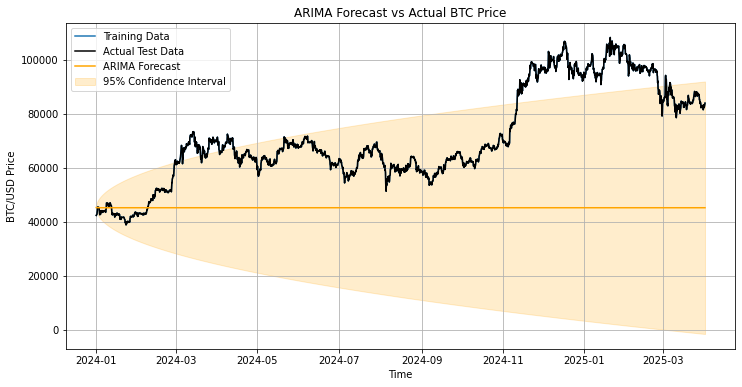

In [33]:
n_test = len(btc_test)
forecast = arima_results.get_forecast(steps=n_test)

predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

predicted_mean.index = btc_test.index
conf_int.index = btc_test.index

forecast_df = pd.DataFrame({
    'actual': btc_test['Close'],
    'predicted': predicted_mean,
    'lower_ci': conf_int.iloc[:, 0],
    'upper_ci': conf_int.iloc[:, 1],
})

forecast_df['residual'] = forecast_df['actual'] - forecast_df['predicted']

plt.figure(figsize=(12,6))
plt.plot(btc_test['Close'], label='Training Data')
plt.plot(btc_test['Close'], label='Actual Test Data', color='black')
plt.plot(predicted_mean, label='ARIMA Forecast', color='orange')
plt.fill_between(btc_test.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='orange', alpha=0.2, label='95% Confidence Interval')
plt.title('ARIMA Forecast vs Actual BTC Price')
plt.xlabel('Time')
plt.ylabel('BTC/USD Price')
plt.legend()
plt.grid()
plt.show()

We notice that the ARIMA model's predicitons converges to a flat line around 45200, suggesting that the model has learned that changes in prices are mostly unpredictable and that the current price is the best forecast for the next price. This makes snese in that BTC/USD prices is white noise. Our conclusion is that the ARIMA models works poorly when trying to develop a trading strategy for BTC/USD.

### Ensembled Models Based


We used daily historical data for BTC/USDT. The dataset included price and volume data and we added a comprehensive set of 60 technical indicators.The indicators added are the following:

![Indicators](indicators.png)

The data was split chronologically, with test data as the last 10000 dates, and it could be changed as per the requirement.



We ensembled XGBoost, LightGBM, and CatBoost to work on the high dimension data, as these models are capable of handling volatility prediction, no extra Trade Yes/No indicator was used.

The ensembled model would predict the reutrn % on nth day and on basis of that trade decision would be made.

In our model, we use R² score as the evaluation metric, which is a standard for regression problems.

 BTC R² Score:-0.40984356957489454

As the R² was pretty poor and other strategies was working better, we didnt invest more time in the ensembled model

In [ ]:
!pip install lightgbm==4.2.0 -i https://mirrors.aliyun.com/pypi/simple/
!pip install catboost==1.2.7 -i https://mirrors.aliyun.com/pypi/simple/
!pip install xgboost==2.0.3 -i https://mirrors.aliyun.com/pypi/simple/
!pip install joblib==1.4.2 -i https://mirrors.aliyun.com/pypi/simple/
!pip install polars==0.18.3 -i https://mirrors.aliyun.com/pypi/simple/
!python ensemble.py

In [2]:
# Importing necessary ML libraries
import os
import joblib
import polars as pl
import lightgbm as lgb
import xgboost as xgb
import catboost as cbt
from joblib import Parallel, delayed
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

/Users/philipmaurstaduv/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/philipmaurstaduv/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


AttributeError: module 'pandas.core.strings' has no attribute 'StringMethods'

In [3]:
%%writefile ensemble.py


skip_dates = 2    # Number of dates to skip from the beginning of the dataset
N_fold = 5    # Number of folds for cross-validation
TRAINING = True
num_valid_dates = 90
test_data_points=10000

input_path = "btc-1-min-data" if os.path.exists("btc-1-min-data") else "btc-1-min-data"
# loading the data from the folder and makinng a single  df-
# using 3 years data for training -
file_path = f"{input_path}/BTC_2019_2023_1m.csv"
chunk = pd.read_csv(file_path)
# For example, 100 rows
## test data set - as last 1 lakh data points and rest above as training-
test = chunk.copy().iloc[len(chunk) - 100000 :]
unprocessed_test = test.copy()
# Convert 'datetime' to datetime format
test["datetimes"] = pd.to_datetime(test["datetime"], errors="coerce")
#Check for any invalid values in the datetime column
if test["datetimes"].isnull().any():
  print("Warning: Some entries in the 'datetime' column could not be parsed!")
  print(test[test["datetimes"].isnull()])  # Display rows with invalid datetime values
# Proceed with further processing
test["date"] = test["datetimes"].dt.date  # Extract the date part
test["date_id"] = (test["date"].astype("category").cat.codes)
# Create unique IDs for each date
print(" all files imported")
df = chunk.copy().iloc[: len(chunk) - 100000]
df["datetimes"] = pd.to_datetime(df["datetime"], errors="coerce")
# Check for any invalid values in the datetime column
if df["datetimes"].isnull().any():
  print("Warning: Some entries in the 'datetime' column could not be parsed!")
  print(df[test["datetimes"].isnull()])  # Display rows with invalid datetime values

# Proceed with further processing
df["date"] = df["datetimes"].dt.date  # Extract the date part
df["date_id"] = (df["date"].astype("category").cat.codes)  # Create unique IDs for each date

dates = df["datetime"].unique()
valid_dates = dates[-num_valid_dates:]

# Define training dates as all dates except the last `num_valid_dates` dates
train_dates = dates[:-num_valid_dates]

df["Target"] = df["close"].shift(-15)  # Shift the 'Close' column by -15 steps
df["Target"] = (
    (df["Target"] - df["close"]) / df["close"]
) * 100  # Compute percentage return

# Handle NaN values for rows that don't have a full future window
df["Target"] = df["Target"].fillna(0)

test["Target"] = test["close"].shift(-15)  # Shift the 'Close' column by -15 steps
test["Target"] = (
    (test["Target"] - test["close"]) / test["close"]
) * 100  # Compute percentage return

# Handle NaN values for rows that don't have a full future window
test["Target"] = test["Target"].fillna(0)

def preprocess_data(df):

    # Basic preprocessing steps (example)
    """
    Preprocess the data by calculating various technical indicators.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the stock data.

    Returns
    -------
    pandas.DataFrame
        The preprocessed DataFrame with the calculated technical indicators.
    """

    stock = df
    stock["Close"] = stock["close"]
    stock["Open"] = stock["open"]
    stock["High"] = stock["high"]
    stock["Low"] = stock["low"]
    stock["Volume"] = stock["volume"]
    data = stock

    del stock

    windows = [5, 10, 15, 20]
    for i in windows:
        # Calculate the 10-day SMA
        data[f"{i}_SMA"] = data["Close"].rolling(window=i, min_periods=i).mean()

    for i in windows:

        weights = np.arange(1, i + 1)

        # Function to calculate WMA for each rolling window
        def calc_wma(values):
            return np.dot(values, weights) / weights.sum()

        # Calculate the 10-day WMA using the custom function
        data[f"{i}_WMA"] = (
            data["Close"].rolling(window=i, min_periods=i).apply(calc_wma, raw=True)
        )

    for i in windows:

        # Calculate the smoothing factor (alpha)
        alpha = 2 / (i + 1)

        # Function to calculate EMA
        def calculate_ema(series, alpha):
            ema = series.ewm(span=i, adjust=False).mean()
            return ema

        # Calculate the 10-day EMA
        data[f"{i}_EMA"] = calculate_ema(data["Close"], alpha)

    window = 5

    def calculate_stochastic_k(data, window):
        # Calculate the rolling high and low from the Close over the specified window
        high_roll = data["Close"].rolling(window=i, min_periods=1).max()
        low_roll = data["Close"].rolling(window=i, min_periods=1).min()

        # Calculate the %K using the typical formula
        stochastic_k = (data["Close"] - low_roll) / (high_roll - low_roll) * 100

        # Apply EMA to the %K values

        return stochastic_k

    data["Stochastic_K"] = calculate_stochastic_k(data, window)

    window = 5

    def calculate_stochastic_d(stochastic_k, window):
        # Apply EMA to the %K EMA values to get %D
        stochastic_d = stochastic_k.ewm(span=window, adjust=False).mean()
        return stochastic_d

    # Assuming your DataFrame is named 'data' and contains 'Close' column

    data["Stochastic_D"] = calculate_stochastic_d(data["Stochastic_K"], 5)

    rsi_window = 14  # Typically, a 14-period window is used

    # Function to calculate RSI using EMA
    def calculate_rsi(data, window):
        # Calculate the price changes
        delta = data["Close"].diff()

        # Separate gains and losses
        gains = delta.where(delta > 0, 0)
        losses = -delta.where(delta < 0, 0)

        # Calculate the exponential moving averages (EMA) of gains and losses
        avg_gain = gains.ewm(span=window, adjust=False).mean()
        avg_loss = losses.ewm(span=window, adjust=False).mean()

        # Calculate the Relative Strength (RS)
        rs = avg_gain / avg_loss

        # Calculate the RSI
        rsi = 100 - (100 / (1 + rs))

        return rsi

    data["RSI"] = calculate_rsi(data, rsi_window)

    # macd-
    # Define the window sizes for MACD calculation
    short_window_1 = 5  # 12-period for the short-term EMA
    long_window_1 = 15  # 26-period for the long-term EMA
    # 9-period for the signal line
    short_window_2 = 5
    long_window_2 = 20

    short_window_3 = 5
    long_window_3 = 10

    # Function to calculate MACD
    def calculate_macd(data, short_window, long_window):
        # Calculate the short-term EMA
        short_ema = data["Close"].ewm(span=short_window, adjust=False).mean()

        # Calculate the long-term EMA
        long_ema = data["Close"].ewm(span=long_window, adjust=False).mean()

        # Calculate the MACD line (difference between short-term EMA and long-term EMA)
        macd = short_ema - long_ema
        return macd

    # Assuming your DataFrame is named 'data' and contains 'Close' column
    data["MACD_1"] = calculate_macd(data, short_window_1, long_window_1)
    data["MACD_2"] = calculate_macd(data, short_window_2, long_window_2)
    data["MACD_3"] = calculate_macd(data, short_window_3, long_window_3)

    # larry williams--
    for i in windows:
        # Define the window size for Williams %R calculation
        williams_r_window = i  # Typically, a 14-period window is used

        # Function to calculate Williams %R using Close
        def calculate_williams_r(data, window):
            # Calculate the highest price over the window
            high_n = data["Close"].rolling(window=window).max()

            # Calculate the lowest price over the window
            low_n = data["Close"].rolling(window=window).min()

            # Calculate Williams %R
            williams_r = ((high_n - data["Close"]) / (high_n - low_n)) * -100

            return williams_r

        # Assuming your DataFrame is named 'data' and contains 'Close' column
        data[f"Williams_%R_{i}"] = calculate_williams_r(data, williams_r_window)

    def calculate_rdp(data, x):
        # Calculate the moving average (CLt-x)
        moving_average = data["Close"].rolling(window=x).mean()

        # Calculate RDP (RDPt)
        rdp = ((data["Close"] - moving_average) / moving_average) * 100

        return rdp

    for i in windows:

        data[f"RDP_{i}"] = calculate_rdp(data, i)

    # Bias
    def calculate_bias(data, interval):
        # Calculate the moving average
        moving_average = data["Close"].rolling(window=interval).mean()

        # Calculate Bias
        bias = (data["Close"] - moving_average) / moving_average

        return bias

    # You can change this to any desired interval
    for i in windows:
        # Calculate Bias and add it as a new column in the DataFrame
        data[f"Bias_{i}"] = calculate_bias(data, i)

    def calculate_mtm(data, interval):

        moving_average = data["Close"].rolling(window=interval).mean()

        # Calculate Momentum (MTM)
        mtm = data["Close"] - moving_average

        return mtm

    for i in windows:
        # You can change this to any desired interval

        # Calculate MTM and add it as a new column in the DataFrame
        data[f"MTM_{i}"] = calculate_mtm(data, i)

    def calculate_roc(data, interval):
        # Calculate the moving average of 'Close'
        moving_average = data["Close"].rolling(window=interval).mean()

        # Calculate Rate of Change (ROC)
        roc = data["Close"] / moving_average

        return roc

    for i in windows:
        # Calculate ROC and add it as a new column in the DataFrame
        data[f"ROC_{i}"] = calculate_roc(data, i)

    def calculate_oscp(data, x_interval, y_interval):
        # Calculate the moving average for both columns
        ma_x = data["Close"].rolling(window=x_interval).mean()
        ma_y = data["Close"].rolling(window=y_interval).mean()

        # Calculate OSCP
        oscp = (ma_x - ma_y) / ma_x

        return oscp

    # Calculate OSCP and add it as a new column in the DataFrame
    data["OSCP_1"] = calculate_oscp(data, short_window_1, long_window_1)
    data["OSCP_2"] = calculate_oscp(data, short_window_2, long_window_2)
    data["OSCP_3"] = calculate_oscp(data, short_window_3, long_window_3)

    def calculate_median_price(data, period):
        # Calculate the highest high and lowest low over the specified period
        highest_high = data["High"].rolling(window=period).max()
        lowest_low = data["Low"].rolling(window=period).min()

        # Calculate Median Price
        median_price = (highest_high + lowest_low) / 2

        return median_price

    # Define the period for calculation
    period = 10  # You can change this to any desired period

    # Calculate Median Price and add it as a new column in the DataFrame
    data[f"Median_Price_{period}"] = calculate_median_price(data, period)

    data["highest_high"] = data["High"].rolling(window=period).max()
    data["lowest_low"] = data["Low"].rolling(window=period).min()

    def calculate_signal_line(data, period_x, period_y):
        # Calculate SMA for x and y
        data[f"SMA_{period_x}"] = data["Close"].rolling(window=period_x).mean()
        data[f"SMA_{period_y}"] = data["Close"].rolling(window=period_y).mean()

        # Calculate the Signal Line
        data["Signal_Line"] = (1 / (10 * data[f"SMA_{period_y}"])) * (
            data[f"SMA_{period_x}"] - data[f"SMA_{period_y}"]
        ) + data[f"SMA_{period_y}"]
        return data

    # Define the periods for SMA calculation
    period_x = 10  # Period for SMA of x (you can change this)
    period_y = 20  # Period for SMA of y (you can change this)

    # Calculate the Signal Line and add it to the DataFrame
    data = calculate_signal_line(data, period_x, period_y)

    def calculate_ultimate_oscillator(data, short_period, mid_period, long_period):
        # Calculate moving averages over different periods
        avg_x = data["Close"].rolling(window=short_period).mean()
        avg_y = data["Close"].rolling(window=mid_period).mean()
        avg_z = data["Close"].rolling(window=long_period).mean()

        # Calculate the Ultimate Oscillator
        data["UO"] = 100 * (1 / (4 + 2 + 1)) * (4 * avg_x + 2 * avg_y + avg_z)

        return data

    # Define the periods for short, mid, and long-term moving averages
    short_period = 10  # Short-term moving average period
    mid_period = 20  # Mid-term moving average period
    long_period = 30  # Long-term moving average period

    # Calculate the Ultimate Oscillator and add it to the DataFrame
    data = calculate_ultimate_oscillator(data, short_period, mid_period, long_period)

    def calculate_bp_tr(data):

        data["BP"] = data["Close"] - data[["Low", "Close"]].shift(1).min(axis=1)

        # True Range (TR)
        data["TR"] = data[["High", "Close"]].shift(1).max(axis=1) - data[
            ["Low", "Close"]
        ].shift(1).min(axis=1)

        return data

    # Function to calculate Ultimate Oscillator (UO)
    def calculate_ultimate_oscillator(
        data, short_period=7, medium_period=14, long_period=28
    ):
        # Calculate BP and TR
        data = calculate_bp_tr(data)

        # Rolling averages of BP/TR for different timeframes
        avg_x = (
            data["BP"].rolling(window=short_period).sum()
            / data["TR"].rolling(window=short_period).sum()
        )
        avg_y = (
            data["BP"].rolling(window=medium_period).sum()
            / data["TR"].rolling(window=medium_period).sum()
        )
        avg_z = (
            data["BP"].rolling(window=long_period).sum()
            / data["TR"].rolling(window=long_period).sum()
        )

        # Ultimate Oscillator formula
        data["UO"] = 100 * ((4 * avg_x) + (2 * avg_y) + (1 * avg_z)) / (4 + 2 + 1)

        return data

    # Define periods for short, medium, and long timeframes
    short_period = 10
    medium_period = 20
    long_period = 30

    # Calculate Ultimate Oscillator and add it to the DataFrame
    data = calculate_ultimate_oscillator(data, short_period, medium_period, long_period)

    def calculate_ulcer_index(data, window):
        # Calculate the highest high over the window (HH)
        hh = data["Close"].rolling(window=window).max()

        # Calculate Rt(x)
        rt = 100 * (data["Close"] - hh) / hh

        # Square the Rt values (as per the formula)
        rt_sq = rt**2

        # Ulcer Index (root of the average squared drawdowns)
        data["Ulcer_Index"] = np.sqrt(rt_sq.rolling(window=window).mean())

        return data

    # Define the window for the Ulcer Index calculation
    ulcer_window = 10  # You can change this window

    # Calculate the Ulcer Index and add it to the DataFrame
    data = calculate_ulcer_index(data, ulcer_window)

    def ema(series, span):
        return series.ewm(span=span, adjust=False).mean()

    # Function to calculate TSI
    def calculate_tsi(data, window):
        # Calculate the Momentum (MTM)
        mtm = data["Close"] - data["Close"].shift(1)

        # Apply EMA to the MTM for the first smoothing
        ema_mtm = ema(mtm, window)

        # Apply a second EMA to the already smoothed MTM
        Double_EMA_MTM = ema(ema_mtm, window)

        # Calculate the absolute value of MTM and apply EMA twice
        Abs_MTM = mtm.abs()
        EMA_Abs_MTM = ema(Abs_MTM, window)
        Double_EMA_Abs_MTM = ema(EMA_Abs_MTM, window)

        # Calculate the TSI
        data["TSI"] = 100 * (Double_EMA_MTM / Double_EMA_Abs_MTM)

        return data

    # Define the window for the TSI calculation
    tsi_window = 25  # Typical value is 25, but you can adjust

    # Calculate TSI and add it to the DataFrame
    data = calculate_tsi(data, tsi_window)

    def calculate_ad_oscillator(data):

        # Calculate the A/D oscillator value using the formula (HighPrice - ClosePrice(t-1)) / (HighPrice - LowPrice)
        data["A/D Oscillator"] = (data["High"] - data["Close"].shift(1)) / (
            data["High"] - data["Low"]
        )
        return data

    # Calculate the A/D Oscillator
    data = calculate_ad_oscillator(data)

    from sklearn.preprocessing import StandardScaler

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit and transform the data
    cols = list(data.columns)  # Convert to a list
    cols = [
        col for col in cols if col not in ["datetime", "datetimes", "date", "date_id"]
    ]  # Remove unwanted columns
    data[cols] = data[cols].replace([np.inf, -np.inf], np.nan)
    data[cols] = data[cols].fillna(0)
    standardized_data = scaler.fit_transform(data[cols])

    # Create a new DataFrame with standardized values

    data_df = pd.DataFrame(standardized_data, columns=cols)
    data_df["datetime"] = data["datetime"]
    data_df["date_id"] = data["date_id"]

    return data_df


print("data pre-processing started")
df = preprocess_data(df)
print(df.head())
test = preprocess_data(test)
print(test.head())
print(df.shape)
print("data pre-processing done")

from sklearn.model_selection import train_test_split

os.system("mkdir models")
print("started")
# Define the path to load pre-trained models (if not in training mode)
model_path = "models"

# If in training mode, prepare validation data
if TRAINING:
    print("training data prep")

    # Extract features, target, and weights for validation dates
    y_valid = df["Target"]
    # df.drop(["Target"], axis =1, inplace = True)
    cols = df.columns

    X_valid = df[cols]
    X_valid.drop(["Target", "datetime", "date_id"], axis=1, inplace=True)
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_valid, y_valid, test_size=0.2, random_state=42
    )

    # Sample 500,000 rows from X_train
    samples = 500000
    X_train = X_train.sample(samples, replace=False, random_state=None)

    # Now get the corresponding rows from y_train
    y_train = y_train.loc[X_train.index]


# Initialize a list to store trained models
modelss = []


# Function to train a model or load a pre-trained model
def train(model_dict, model_name="lgb"):
    """
    Train a machine learning model using the specified configuration.

    Parameters
    ----------
    model_dict : dict
        A dictionary containing model configurations for LightGBM, XGBoost, and CatBoost.
    model_name : str, optional
        The name of the model to train ('lgb', 'xgb', or 'cbt'), by default 'lgb'.

    Description
    -----------
    This function handles the training and validation of machine learning models. It selects
    training data based on fold number, preprocesses features and targets, and trains the model
    with early stopping and evaluation logging. The trained model is saved to disk, and models
    are loaded from disk if not in training mode.
    """
    print(f"Training {model_name} model for fold {i}...")

    if TRAINING:
        # Select dates for training based on the fold number
        print("Selecting dates for training...")
        selected_dates = [
            date for ii, date in enumerate(train_dates) if ii % N_fold != i
        ]

        # Get the model from the dictionary
        print("Getting the model from the dictionary...")
        model = model_dict[model_name]

        # Extract features, target, and weights for the selected training dates
        print(
            "Extracting features, target, and weights for the selected training dates..."
        )
        y_valid = df["Target"]
        cols = df.columns
        X_valid = df[cols]
        X_valid.drop(["Target", "datetime", "date_id"], axis=1, inplace=True)
        X_train, X_valid, y_train, y_valid = train_test_split(
            X_valid, y_valid, test_size=0.2, random_state=42
        )

        print("Sampling 500,000 rows from X_train...")
        samples = len(df)//2
        X_train = X_train.sample(samples, replace=False, random_state=None)

        # Now get the corresponding rows from y_train
        print("Getting the corresponding rows from y_train...")
        y_train = y_train.loc[X_train.index]

        # Train the model
        if model_name == "lgb":
            # Train LightGBM model with early stopping and evaluation logging
            model.fit(
                X_train,
                y_train,
                eval_metric=[r2_lgb],
                eval_set=[(X_valid, y_valid)],
                callbacks=[lgb.early_stopping(100), lgb.log_evaluation(10)],
            )

        elif model_name == "cbt":
            # Prepare evaluation set for CatBoost
            evalset = cbt.Pool(X_valid, y_valid)

            # Train CatBoost model with early stopping and verbose logging
            model.fit(
                evalset,
                use_best_model=True,  # Keeps the best model based on validation set
                verbose=200,  # Logs progress every 100 iterations
            )

        else:
            # Train XGBoost model with early stopping and verbose logging
            model.fit(
                X_train,
                y_train,
                eval_set=[(X_valid, y_valid)],
                verbose=10,
                early_stopping_rounds=200,
            )

        # Append the trained model to the list
        modelss.append(model)

        # Save the trained model to a file
        joblib.dump(model, f"./models/{model_name}_{i}.model")

        # Collect garbage to free up memory
        import gc

        gc.collect()

    else:
        # If not in training mode, load the pre-trained model from the specified path
        modelss.append(joblib.load(f"{model_path}/{model_name}_{i}_individual.model"))

    return


# Custom R2 metric for XGBoost
def r2_xgb(y_true, y_pred):
    r2 = 1 - np.mean((y_pred - y_true) ** 2) / (np.mean(y_true**2) + 1e-38)
    return "r2", -r2


# Custom R2 metric for LightGBM
def r2_lgb(y_true, y_pred):
    r2 = 1 - np.mean((y_pred - y_true) ** 2) / (np.mean(y_true**2) + 1e-38)
    return "r2", r2, True  # Return True to maximize the metric


# Custom R2 metric for CatBoost

# Dictionary to store different models with their configurations
model_dict = {
    "lgb": lgb.LGBMRegressor(
        n_estimators=500 * 2, device="gpu", gpu_use_dp=True, objective="l2"
    ),
    "xgb": xgb.XGBRegressor(
        n_estimators=2000 ,
        learning_rate=0.1,
        max_depth=6,
        tree_method="hist",
        device="cuda",
        objective="reg:squarederror",
        eval_metric="rmse",
        disable_default_eval_metric=True,
    ),
    "cbt": cbt.CatBoostRegressor(
        iterations=1000 ,
        learning_rate=0.05,
        task_type="GPU",
        loss_function="RMSE",
        eval_metric="R2",
    ),
}

print("calling the train fns")
# Train models for each fold

for i in range(N_fold):
  print(f"{i} th fold training ")
  print("lgb")
  train(model_dict, "lgb")
  print("xgb")
  train(model_dict, "xgb")
  print("cbt")
  train(model_dict, "cbt")


y_test = test["Target"][:test_data_points]  # Take the first 10,000 points only
print("Started")

# Prepare the feature set
X_test = test.iloc[:test_data_points].drop(["Target", "datetime", "date_id"], axis=1)

pred = np.array(
    [model.predict(X_test) for model in modelss]
)  # Shape: (n_models, 10000)
# Average predictions across all models
pred_mean = np.mean(pred, axis=0)  # Shape: (10000,)

# Calculate R² score for the first 10,000 points
r2 = r2_score(y_test, pred_mean)
print(f"R² Score: {r2}")


# Saving the predictions

colss = ["open", "high", "close", "low", "volume"]
X_test = X_test[colss]
unprocessed_test = unprocessed_test.iloc[:test_data_points]
unprocessed_test["target_returns"] = y_test
unprocessed_test["predicted_mean"] = pred_mean
X_test["Target_returns"] = y_test
X_test["predicted_mean"] = pred_mean
print(X_test.head())
unprocessed_test.to_csv(f"{stock}_test_predicted.csv", index=False)

Writing ensemble.py


### Statistical Strategy

As mentioned in the Empirical Analysis section, multiple moving average indicators were tried, but in the end we settled with Hull Moving Average (HMA) due to its superior performance and balance between accuracy and responsiveness.

The final strategy could be defined as the following:

**Supertrend Indicator**

*   Its role is to identify choppy or highly volatile market conditions. If market is highly choppy, we will not do any trade because as observed before, MA indicators lead to false entries in volatile market conditions.

We had two options for supertrend indicator:

1. ATR (Average True Range): Easier to apply. The Supertrend will use ATR values to create an upper and lower band around the price. By aligning signals with HMA crossovers, the Supertrend filters out false entries in volatile or sideways market conditions.
2. HAR: Using HAR predictions to identify choppy market conditions to filter out false entries in volatile market.

**HMA Indicator**

*   The HMA calculation begins with two WMAs—first, a shorter-period WMA and second, a long period WMA.
*   A buy signal occurs when the fast HMA (e.g., 10-period) crosses above the slow HMA
 (e.g., 30-period), indicating potential upward momentum. Conversely, a sell signal is generated when
 the fast HMA crosses below the slow HMA, signaling a downward trend.


 **Parameter Estimation**

 We need to estimate values of time sensitive HMA lenghts and the threshold to indicate high volitile conditions based on HAR prediction.
 Based on our initial trials, we used 30 day period for slow HMA and 1 day period for fast HMA, but planned on applying the following system for more dynamic parameter estimation:

 1. **Polynomial Regression**: The BTC market exhibit logarithmic growth trends, where price increases become less explosive over time. This deceleration pattern can be captured by polynomial regression to identify slowing market trends for selection of HMA lenghts. (Example: If market deccelerates, longer HMAs can be used to smooth out noise while maintaining responsiveness.)

 2. **Decision Tree**: A decision tree based classifier was used to identify threshold for high volatility conditions on basis of HAR prediction values.


**NOTE**: The planned dynamic parameter estimation using regression and decision tree was not applied due to lack of time.



In [ ]:
%%writefile stat_strat.py
import pandas as pd
from untrade.client import Client
from pprint import pprint
import talib as ta
import numpy as np

def hma(series, period):
    half_length = period // 2
    sqrt_length = int(np.sqrt(period))
    wma_half = ta.WMA(series, half_length)
    wma_full = ta.WMA(series, period)
    hma_series = ta.WMA(2 * wma_half - wma_full, sqrt_length)
    return hma_series

def supertrend(df, period=7, multiplier=3):
    atr = ta.ATR(df['high'], df['low'], df['close'], timeperiod=period)
    hl2 = (df['high'] + df['low']) / 2
    upper_band = hl2 + (multiplier * atr)
    lower_band = hl2 - (multiplier * atr)
    supertrend = [True] * len(df)  # True indicates uptrend, False indicates downtrend

    # Fix the indexing warnings by using iloc
    for i in range(1, len(df)):
        if df['close'].iloc[i] > upper_band.iloc[i - 1]:
            supertrend[i] = True
        elif df['close'].iloc[i] < lower_band.iloc[i - 1]:
            supertrend[i] = False
        else:
            supertrend[i] = supertrend[i - 1]
            upper_band.iloc[i] = min(upper_band.iloc[i], upper_band.iloc[i - 1]) if supertrend[i] else upper_band.iloc[i]
            lower_band.iloc[i] = max(lower_band.iloc[i], lower_band.iloc[i - 1]) if not supertrend[i] else lower_band.iloc[i]

    df['supertrend'] = supertrend
    df['supertrend_ub'] = upper_band
    df['supertrend_lb'] = lower_band
    return df

def process_data(data):
    data.drop(data[data['volume'] == 0].index, inplace=True)
    hma_fast_period = 10
    hma_slow_period = 30
    # Calculate HMA
    data['hma_fast'] = hma(data['close'], hma_fast_period)
    data['hma_slow'] = hma(data['close'], hma_slow_period)
    # Calculate Supertrend
    data = supertrend(data, period=7, multiplier=3)
    # Define entry/exit signals row-wise
    def entry_exit_signal(row):
        if row['hma_fast'] > row['hma_slow'] and row['supertrend']:
            return 1  # Buy signal
        elif row['hma_fast'] < row['hma_slow'] and not row['supertrend']:
            return -1  # Sell signal
        else:
            return 0  # No signal
    # Apply the signal generation to each row
    data['Signal'] = data.apply(entry_exit_signal, axis=1)
    return data

def strat(data):
    data.dropna(inplace=True)
    signal = []
    trade_type = []
    prev = None
    for value in data["Signal"]:
        if value == prev:
            signal.append(0)
        else:
            signal.append(value)
        prev = value

    # getting trade signals
    count = 0
    for value in signal:
        if value == 0:
            trade_type.append('')
        elif count == 1:
            if value == -1:
                trade_type.append('close')
                count = 0
            else:
                trade_type.append('')
        elif count == -1:
            if value == 1:
                trade_type.append('close')
                count = 0
            else:
                trade_type.append("")
        elif count == 0:
            if value == 1:
                trade_type.append('long')
                count = 1
            elif value == -1:
                trade_type.append('short')
                count = -1
            else:
                trade_type.append('')
        else:
            trade_type.append('')

    data["signals"] = signal
    data["trade_type"] = trade_type

    # Keep only the necessary columns including datetime
    data = data[['open', 'high', 'low', 'close', 'volume', 'signals', 'trade_type']].copy()

    # Reset index and make sure datetime is a proper column
    data.reset_index(inplace=True)
    data['datetime'] = pd.to_datetime(data['datetime'], format='%d/%m/%Y %H:%M')
    data['datetime'] = data['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
    return data

def perform_backtest(csv_file_path):
    # Create an instance of the untrade client
    client = Client()
    # Perform backtest using the provided CSV file path
    result = client.backtest(
        jupyter_id="dnfy.",  # the one you use to login to jupyter.untrade.io
        file_path=csv_file_path,
        leverage=1,
    )
    return result

def main():
    # Read data from CSV file
    data = pd.read_csv('BTCUSDT_4h_train_data.csv', parse_dates=['datetime'], index_col='datetime')

    # Process data
    processed_data = process_data(data)

    # Apply strategy
    strategy_signals = strat(processed_data)

    # Save processed data to CSV file with formatted datetime
    strategy_signals.to_csv("results.csv", index=False)

    backtest_result = perform_backtest("results.csv")
    print(backtest_result)

    for value in backtest_result:
        print(value)

if __name__ == "__main__":
    main()

Writing stat_strat.py


Final Results:

![Results stat_strat](results.png)

The trading strategy was largely successful, yielding a profit percentage of 1644 %.

## Conclusion

This project demonstrates the potential of combining statistical models and machine learning techniques to create a robust BTC/USD trading strategy. By analyzing historical data and testing various models, from ARIMA and GARCH to XGBoost, we identified patterns and predictive signals that can inform profitable trading decisions. While ARIMA worked poorly, Hull Moving Average provided promising results. While the results are promising, real-world application would require continuous model updating, risk management, and awareness of changing market dynamics.

## Use of LLMs

Throughout this project, we utilized Large Language Models (LLMs), specifically ChatGPT, to assist with debugging our Python code and to generate ideas on solving specific technical problems, including identifying relevant Python libraries and functions. Additionally, we used Grammarly and ChatGPT for proofreading, eliminating spelling errors, and enhancing the precision and clarity of the written text in our report.